# Tutorial 0 - Particle sizing

Welcome to the first tutorial of this series! In this notebook, we'll explore one of the simplest yet insightful applications of Differential Dynamic Microscopy (DDM): particle sizing. Throughout this exploration, we'll be assisted by **fastDDM**, a robust and efficient Python package.

Whether you're a seasoned researcher in the field of soft matter physics or a curious enthusiast, this notebook aims to provide a hands-on experience in leveraging DDM to uncover the hidden dynamics within colloidal systems.

### Purpose

The aim of this tutorial is to guide you through the basic principles of DDM and illustrate the functionalities offered by **fastDDM**. Specifically, we will:

1. Load an image sequence with the help of `read_images()`.
2. Obtain a structure function from the image sequence and explore its properties.
3. Calculate the azimuthal average of the structure function.
4. fit the azimuthal average to gain insights into the sample's dynamics.
5. Convert the dynamical properties into particle size.

## Setting up your workspace

We assume you have already installed **fastDDM** and the necessary packages required for scientific analysis, fitting, and visualization on your machine (refer to the main [README](../README.md)).

For this tutorial, we will need the [open-source microscopy videos](https://datashare.ed.ac.uk/handle/10283/4858) accompanying the paper [Bradley et al, *Soft Matter*, 2023, **19**, 8179](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c). Download all files and unzip the main folder (and the `Video_dataset.zip` within it) in the directory containing this notebook (go grab a coffee, it will take a while).
Your directory tree will look like this:
```
Tutorial_0-Particle_sizing
│   tutorial0.ipynb    
│
└───DS_10283_4858
    │   ...
    │
    └───Video_dataset
        |
        └───third_vid_dataset
            |
            └───...
```

## Samples description

According to the [reference article](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c), the samples under study consist of dilute solutions of polystyrene (PS) spheres with various sizes dispersed in Milli-Q water.
The batches, obtained from Thermo Scientific (5000 series), have the following diameters:
- 60 nm
- 120 nm
- 240 nm
- 500 nm
- 1.1 $\mu$m
- 2.1 $\mu$m.

These samples are prepared at a volume fraction $\phi=10^{-5}$ and loaded into 0.4 $\times$ 4 $\times$ 50 mm glass capillaries (Vitrocom).
For a more detailed understanding, please refer to the [full article](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c).

## Fasten your seatbelts!

Let's start working with our images. We begin by importing the required packages.

In [29]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fddm
from fastddm.fit import fit

Here, we define the paths to the videos and the labels indicating the nominal particle size.

In [2]:
# directory containing the videos
main_directory = 'DS_10283_4858/Video_dataset/third_vid_dataset/27_07_2021_BF_Scaling_Neat/'

# file names (including enclosing folder)
file_names = [
    'BF20x_1x1_200fps_Pos3_3/BF20x_1x1_200fps_Pos3_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos1_3/BF20x_1x1_200fps_Pos1_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos4_3/BF20x_1x1_200fps_Pos4_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos0_3/BF20x_1x1_200fps_Pos0_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos5_3/BF20x_1x1_200fps_Pos5_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos2_3/BF20x_1x1_200fps_Pos2_3_MMStack_Default.ome.tif',
]

# create full paths
file_paths = [os.path.join(main_directory, fn) for fn in file_names]

# list of labels
labels = [
    '60 nm',
    '120 nm',
    '240 nm',
    '500 nm',
    r'1.1 $\mu$m',
    r'2.1 $\mu$m',
]

The experimental parameters are listed in Sec. 4 of the reference [paper](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c).
Videos are acquired at 200 fps with a Hamamatsu Orca Flash 4.0 camera (pixel size 6.5 $\mu$m) using a 20$\times$, NA 0.5 objective. This gives an effective pixel size of $\delta_{px} = 6.5/20 \, {\mu\mathrm{m}} = 325 \, \mathrm{nm}$.

In [3]:
# experimental parameters
frame_rate = 200       # frames per second
pixel_size = 6.5/20    # microns per pixel

It's always useful start by inspecting the videos. We load the first frame from every movie and display the images in a grid.

<IPython.core.display.Javascript object>


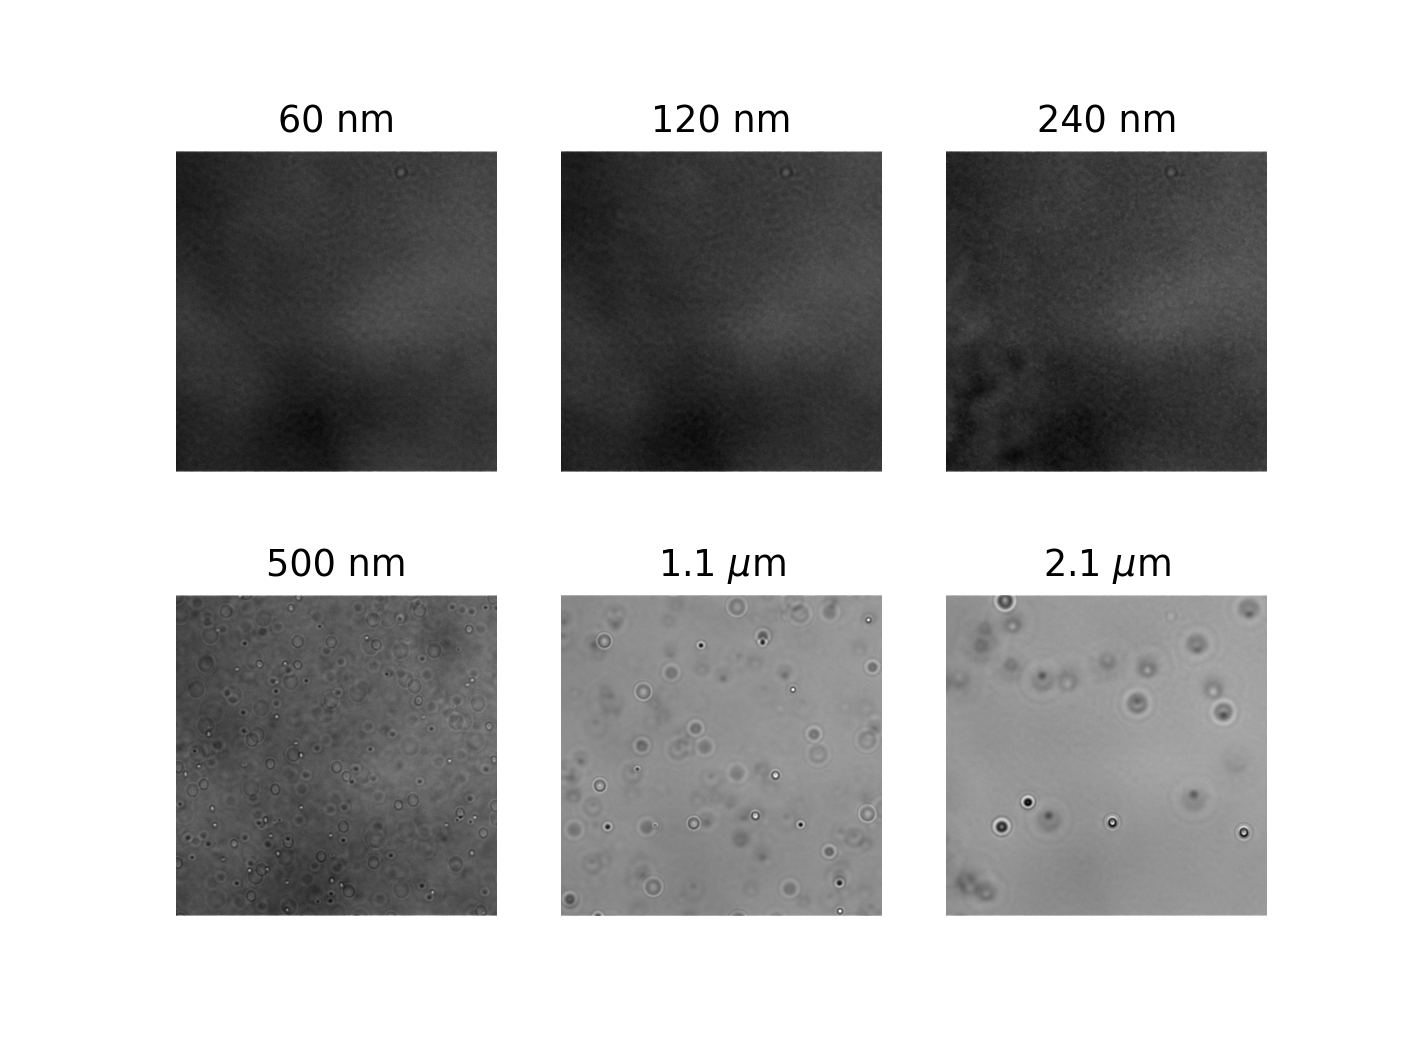

In [4]:
fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=3, nrows=2)
axs = gs.subplots()

# read the images
images = []
for path in file_paths:
    images.append(fddm.read_images(path, seq=[0]))

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

Observe that the particles are visible only in the lower panels (500 nm to 2.1 $\mu$m), whereas they remain indiscernible in the upper panel due to their size being too small to be optically resolved.

## Structure function calculation

The structure function serves as a fundamental tool for revealing spatial correlations and dynamic features within images.

The procedure is the following:

#### Data preparation
We initiate the process by loading the image sequence from the file. To compute the structure function, **fastDDM** requires a 3D NumPy array as input. The time runs over the first axis, while the spatial dimensions (y and x) run over the last two axes.

#### Structure function calculation
Next, we apply DDM to the image sequence to derive the structure function. To provide the necessary experimental context, we input the frame rate and pixel size. These parameters update the time delays ($\Delta t$) and wave vectors ($k$). Bear in mind that these quantities have associated units.

#### Azimuthal average calculation
For isotropic systems, enhancing statistics is achieved by binning the moduli of the 2D wave vectors and averaging the structure function over the wavevector annuli.


We start by analyzing just one video to illustrate the procedure. For this purpose, we use the image sequence corresponding to the PS 240 nm sample. Later, we will analyze all the other movies.

In [5]:
# the index corresponding to the PS 240 nm is 2
idx = 2

# we select the path to the file ...
path = file_paths[idx]

# ... and the label
label = labels[idx]

# finally, we load the image sequence
img_seq = fddm.read_images(path)

# let's see what is the shape of the image sequence
print(img_seq.shape)

(6000, 512, 512)


As indicated in the paper, the videos consist of sequences of 6000 images, 512 $\times$ 512 pixels.

Let's visualize some of the frames.

<IPython.core.display.Javascript object>


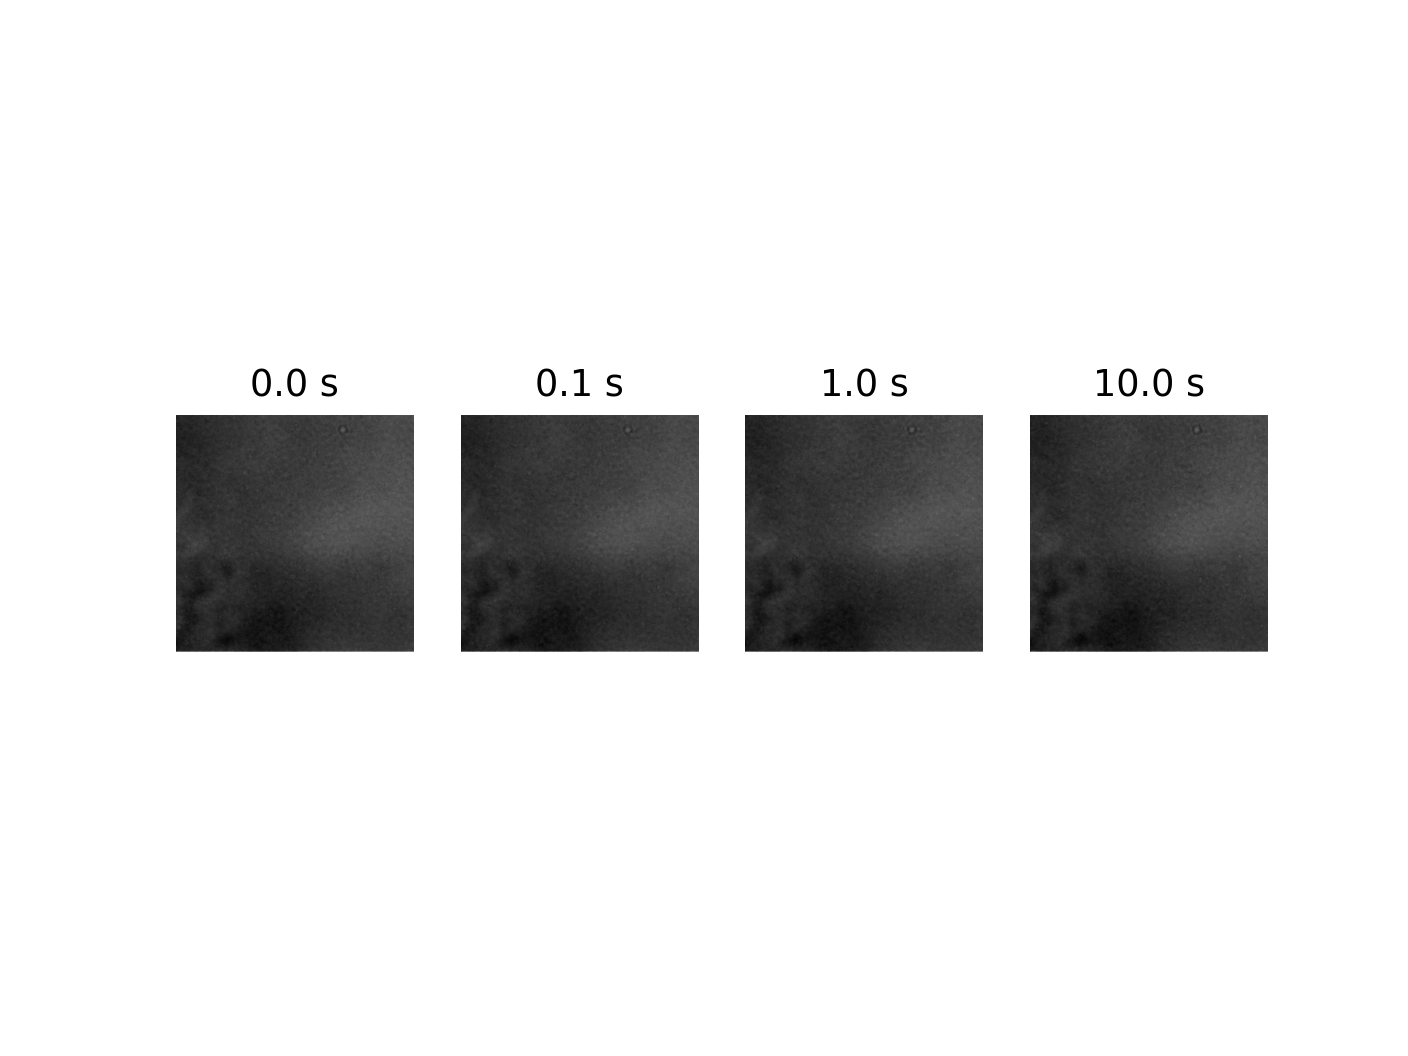

In [11]:
# we want to visualize the 0th, 20th, 200th, and 2000th frame
frame_indices = [0, 20, 200, 2000]

fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=len(frame_indices))
axs = gs.subplots()

for ax, fidx in zip(axs.flatten(), frame_indices):
    ax.imshow(img_seq[fidx], cmap='gray')
    
    # we compute the time delay between two images from the frame rate
    dt = 1 / frame_rate
    # title
    title = f'{fidx * dt} s'
    
    ax.set_axis_off()
    ax.set_title(title)

The small signal from the particles results in all images appearing very similar, representing the spurious static signal generated along the optical path. However, if we subtract the first image...

<IPython.core.display.Javascript object>


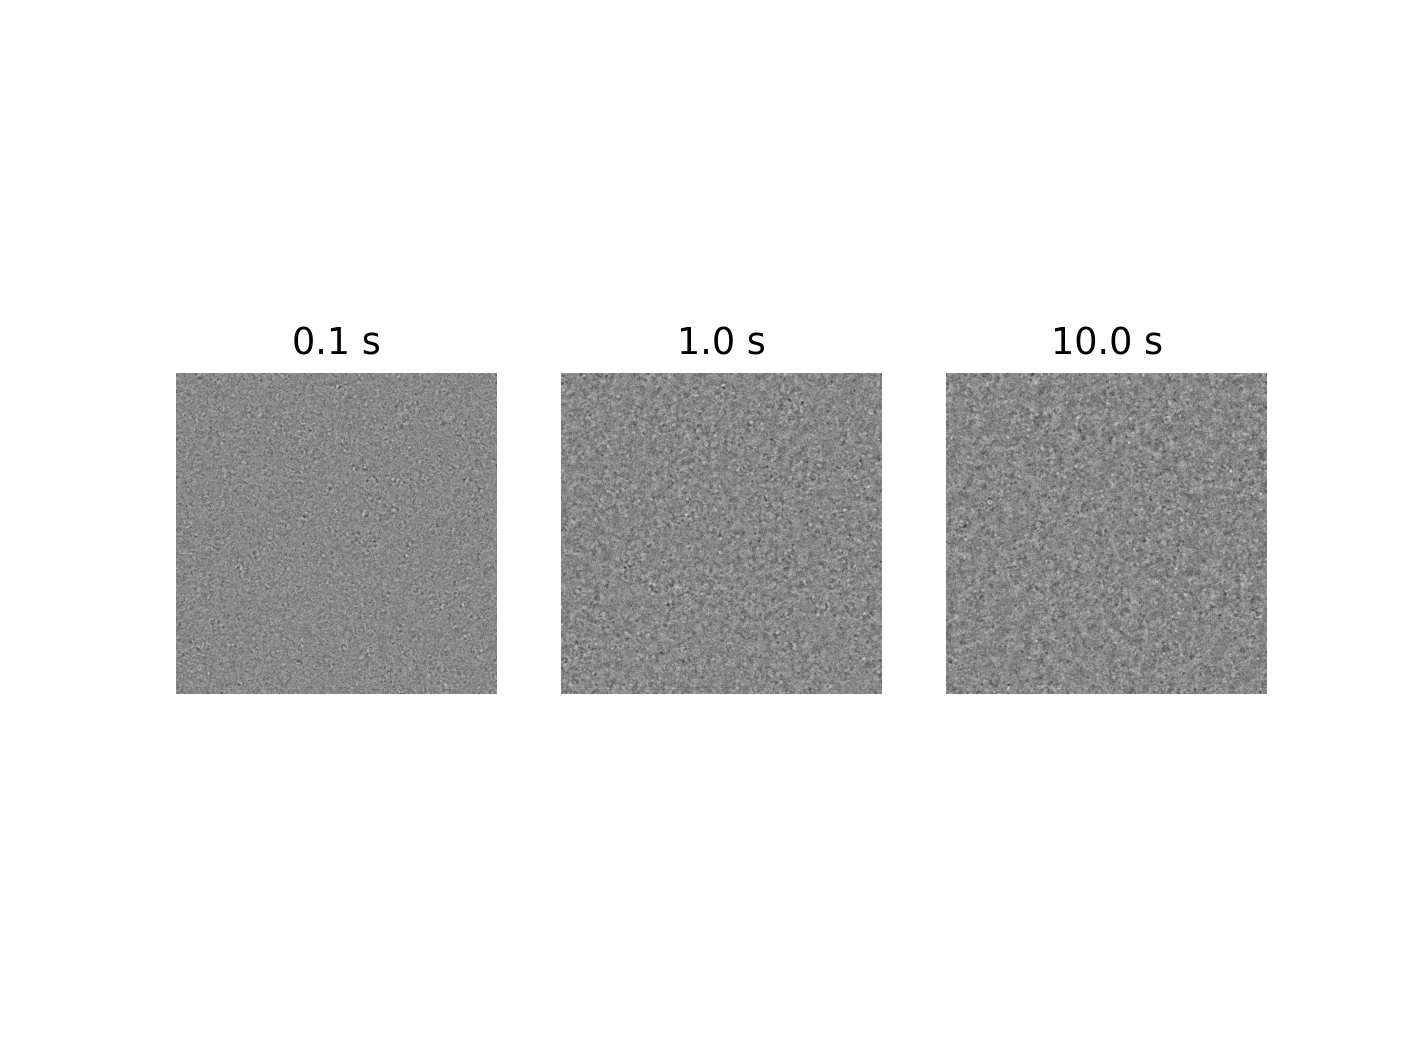

In [22]:
fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=len(frame_indices)-1)
axs = gs.subplots()

# calculate the image differences
delta_images = []
for fidx in frame_indices[1:]:
    delta_images.append(img_seq[fidx].astype(float)-img_seq[0])

for ax, d_img, fidx in zip(axs.flatten(), delta_images, frame_indices[1:]):
    ax.imshow(d_img,
              cmap='gray',
              vmin=np.min(delta_images),
              vmax=np.max(delta_images))
    
    # we compute the time delay between two images from the frame rate
    dt = 1 / frame_rate
    # title
    title = f'{fidx * dt} s'
    
    ax.set_axis_off()
    ax.set_title(title)

Subtracting the reference image taken at time 0 effectively removes the static signal, revealing the specific contribution from the particles. As we extend the time delay ($\Delta t$), the contrast in the resulting images intensifies, capturing the motion of the particles. Additionally, observing the average size of the granularity (speckles) in difference images with longer time delays provides an estimate of the microscope's resolution, particularly when the particle size is below the resolution limit.

We will calculate now the structure function, starting from the image sequence.
Under the hood, we will do the following:
1. Compute the spatial Fourier transform of the images, $I(\mathbf{q},t)=\mathcal{F}_{2D}\{i(\mathbf{x},t)\}$
2. Compute the structure function, defined as
   $$
   D(\mathbf{q},\Delta t) = \langle \lvert I(\mathbf{q}, t+\Delta t) - I(\mathbf{q}, t) \rvert^2 \rangle_t ,
   $$
   where $\langle \cdot \rangle_t$ indicates an average over time.


**FastDDM** provides various core backends for the calculation of the structure function: pure Python, C++, and CUDA.
These can be set by assigning `core` with the values `'py'`, `'cpp'`, and `'cuda'`, for Python, C++, and CUDA, respectively.
Uncomment the one you wish to use here (note that `'py'` is always available).

In addition, two algorithms have been implemented for the calculation of the structure function:
* the standard ('differences') algorithm, given by the definition above.
* the fast algorithm, which takes advantage of the Fast Fourier Transform (FFT) to speed up the computation.

These modes can be selected by assigning `mode` with the values `'diff'` and `'fft'` (the default), respectively.
The results in the two modes are virtually indistinguishable, but the `fft` mode will considerably speed-up your analysis. If you wish to test the difference, feel free to uncomment the `diff` mode (and enjoy your pause from work 🙂).

In [23]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
#CORE = 'py'
#CORE = 'cpp'
CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

Let's have a quick look at the documentation.

In [24]:
help(fddm.ddm)

Help on function ddm in module fastddm._ddm:

ddm(img_seq: numpy.ndarray, lags: Iterable[int], *, core: str = 'py', mode: str = 'fft', window: Union[numpy.ndarray, NoneType] = None, **kwargs) -> fastddm.imagestructurefunction.ImageStructureFunction
    Perform Differential Dynamic Microscopy analysis on given image sequence.
    Returns the full image structure function.
    
    Parameters
    ----------
    img_seq : numpy.ndarray
        Image sequence of shape ``(t, y, x)`` where ``t`` is time.
    lags : Iterable[int]
        The delays to be inspected by the analysis.
    core : str, optional
        The backend core, choose between "py", "cpp", and "cuda".
        Default is "py".
    mode : str, optional
        The mode of calculating the structure function, choose between "diff"
        and "fft". Default is "fft".
    window : numpy.ndarray, optional
        A 2D array containing the window function to be applied to the images.
        Default is None.
    
    Returns
    -

Apart from the image sequence, and the core and mode we already discussed, the function also requires a sequence of `lags`. These are the indices used to evaluate the time lags $\Delta t$. If you wish, they are the time delays normalized by the minimum time difference between two images. (For the moment, forget about the window argument. We will encounter it in one of the next tutorials.)

There are many possible choices. Two of them are:
* A linear range between 1 (at $\Delta t = 0$ the signal is 0 by definition and does not carry any information) and $N-1$, where $N$ is the number of images. This is the most natural one.
* A quasi-logarithmically spaced sequence of integers (if you want to test it, this can be obtained using the function `fddm.lags.logspace_int()`). This produces points almost equally spaced in logarithmic (delay) time.

We will go for the first option.

In [25]:
# define the sequence of lags
lags = range(1, len(img_seq))   # goes from 1 to len(img_seq)-1, included

# compute the image structure function
dqt = fddm.ddm(img_seq,
               lags=lags,
               core=CORE,
               mode=MODE)

Congratulation! You just calculated your first structure function with fastDDM! 🎉

To this point, there is still no experimental context. The time delays and wave vectors are still non-dimensional:

In [30]:
print('--- Before experimental parameters setting ---')
# we can access the time delays through `tau` ...
print(dqt.tau)
# ... and the wave vectors over y via `ky`
print(dqt.ky)

--- Before experimental parameters setting ---
[5.0000e-03 1.0000e-02 1.5000e-02 ... 2.9985e+01 2.9990e+01 2.9995e+01]
[-9.66643893 -9.62867941 -9.59091988 ...  9.55316035  9.59091988
  9.62867941]


We can 'inform' the structure function object of the experimental parameters, such as the pixel size (for the wave vectors) and the frame rate (or the time delay between two images, for the time delays).

In [26]:
# to give some experimental context, we also set the pixel size ...
dqt.pixel_size = pixel_size
# ... and the frame rate
dqt.set_frame_rate(frame_rate)
# this can also be
# dqt.delta_t = 1/frame_rate

In [31]:
print('--- After experimental parameters setting ---')
print(dqt.tau)
print(dqt.ky)

--- After experimental parameters setting ---
[5.0000e-03 1.0000e-02 1.5000e-02 ... 2.9985e+01 2.9990e+01 2.9995e+01]
[-9.66643893 -9.62867941 -9.59091988 ...  9.55316035  9.59091988
  9.62867941]


You will have to keep in mind that these quantities bear units!